loading raw file: ./data/test_32x32.mat
filling input queue
loading batch of samples: 100
DATALOADER ERROR: Enqueue operation was cancelled
	 [[Node: fifo_queue_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_INT64, DT_INT64], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](fifo_queue, _recv_input_images_0, _recv_input_labels_0)]]

Caused by op u'fifo_queue_EnqueueMany', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/l

data stream closed.
thread error:  Enqueue operation was cancelled
	 [[Node: fifo_queue_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_INT64, DT_INT64], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](fifo_queue, _recv_input_images_0, _recv_input_labels_0)]]

Caused by op u'fifo_queue_EnqueueMany', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
 

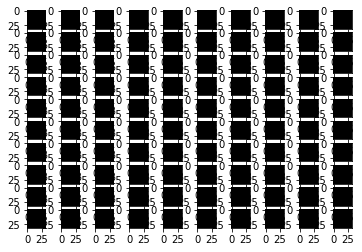

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import os
import threading

from six.moves import xrange
import scipy.io as sio
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf


# configuration
BATCH_SIZE = 100
NUM_SUBPLOT_COLS = 10
DATASET_PATH = "../data/train_32x32.mat"
VALID_DATASET_PATH = "./data/test_32x32.mat"
GEN_TEST_PATH = "../data/test_images.mat"
CROP_H = 24
CROP_W = 24

NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 73257
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 1000

class DataLoader:
  def __init__(self, data_path, batch_size=50, num_valid_samples=None):
    print("loading raw file:", data_path)
    data = sio.loadmat(data_path)
    self.images = data['X']
    self.labels = data['y']
    self.images = np.transpose(self.images, (3, 0, 1, 2))
    self.labels[self.labels==10] = 0
    self.num_valid_samples = num_valid_samples
    self.batch_size = num_valid_samples or batch_size
    if self.num_valid_samples != None:
      self.random_valid_set()
    # create queue
    print("filling input queue")
    self.queue_image = tf.placeholder(tf.int64, shape=[self.batch_size, 32, 32, 3], name="input_images")
    self.queue_label = tf.placeholder(tf.int64, shape=[self.batch_size, 1], name="input_labels")
    self.example_queue = tf.FIFOQueue(
      capacity=int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * 0.4) + 3 * self.batch_size,
      dtypes=[tf.int64, tf.int64],
      shapes=[[32, 32, 3], [1]])
    # self.example_queue = tf.train.input_producer(examples)
    self.enqueue = self.example_queue.enqueue_many([self.queue_image, self.queue_label])

    self.enqueue_thread = None
    self.coord = None
    self.coord = tf.train.Coordinator()
    self.threads = None

  def random_valid_set(self):
    num_valid_samples = self.num_valid_samples
    dataset_size = self.images.shape[0]
    start = np.random.randint(0, dataset_size - num_valid_samples)
    self.images = self.images[start:start+num_valid_samples]
    self.labels = self.labels[start:start+num_valid_samples]
    print("random validation set [%d:%d]" % (start, start+num_valid_samples))
    
  def data_stream(self, session):
    start = 0
    dataset_size = len(self.labels)
    try:
      while not self.coord.should_stop():
      # while True:
        end = start + self.batch_size
        # print("loading [%d:%d] into input queue..." % (start, end))
        if end <= dataset_size:
          image_batch = self.images[start:end]
          label_batch = self.labels[start:end]
          start = end
        else:
          remaining = end - dataset_size
          image_batch = np.concatenate((self.images[start:dataset_size], self.images[0:remaining]))
          label_batch = np.concatenate((self.labels[start:dataset_size], self.labels[0:remaining]))
          start = remaining
        session.run(
          self.enqueue, 
          feed_dict={
            self.queue_image : image_batch,
            self.queue_label : label_batch})
    except Exception as e:
      print("DATALOADER ERROR:", e)
      self.coord.request_stop(e)
    print("data stream closed.")

  def preprocess(self):
    image, label = self.example_queue.dequeue()
    # distorted_image = tf.random_crop(image, [CROP_H, CROP_w, 3])
    if self.num_valid_samples == None:
      distorted_image = tf.image.random_flip_left_right(image)
      distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
      distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    else:
      distorted_image = image
    float_image = tf.image.per_image_standardization(distorted_image)
    return float_image, label

  def load_batch(self):
    image, label= self.preprocess()
    image.set_shape([32, 32, 3])
    label.set_shape([1])
    if self.num_valid_samples != None:
      image_batch, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=self.batch_size,
        num_threads=4,
        capacity=int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * 0.4) + 3 * self.batch_size,
        min_after_dequeue=int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * 0.4))
    else:
      image_batch, label_batch = tf.train.batch(
        [image, label],
        batch_size=self.batch_size,
        num_threads=4,
        capacity=int(NUM_EXAMPLES_PER_EPOCH_FOR_EVAL * 0.4) + 3 * self.batch_size)

    tf.summary.image('images', image_batch)
    print("loading batch of samples:", self.batch_size) 
    return image_batch, tf.reshape(label_batch, [self.batch_size])

  def load(self, session):
    self.enqueue_thread = threading.Thread(target=self.data_stream, args=[session])
    self.enqueue_thread.isDaemon()
    self.enqueue_thread.start()
    self.threads = tf.train.start_queue_runners(coord=self.coord, sess=session)
    
  def close(self, session):
    session.run(self.example_queue.close(cancel_pending_enqueues=True))
    self.coord.request_stop()
    try:
      self.coord.join(self.threads)
    except Exception as e:
      print("thread error: ", e)
    print("dataloader closed successfully.")

if __name__ == "__main__":
  fig = plt.figure()
  num_plot_cols = NUM_SUBPLOT_COLS
  num_plot_rows = int(math.ceil(BATCH_SIZE/num_plot_cols))
  labels = []

  with tf.Graph().as_default():
    dataloader = DataLoader(VALID_DATASET_PATH, BATCH_SIZE)
    image_batch, label_batch = dataloader.load_batch()
    run_options = tf.RunOptions(timeout_in_ms=4000000)
    with tf.Session() as session:
      dataloader.load(session)
      for epoch in range(NUM_EXAMPLES_PER_EPOCH_FOR_EVAL // BATCH_SIZE):
        images, labels = session.run([image_batch, label_batch], options=run_options)
        print(images.shape, labels.shape)
        print(labels)
        for batch_i in range(BATCH_SIZE):
          sub_plot = fig.add_subplot(num_plot_rows, num_plot_cols, batch_i+1)
          plt.imshow(images[batch_i])
      dataloader.close(session)
  plt.show()

